In [235]:
import pandas as pd
from datetime import datetime,timedelta
import calendar
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import glob
import os
import numpy as np

warnings.simplefilter('ignore')

train_data_file_path = "/work/data/input/google-smartphone-decimeter-challenge/baseline_locations_train.csv"
test_data_file_path = "/work/data/input/google-smartphone-decimeter-challenge/baseline_locations_test.csv"

## 曜日

### 必要な関数

In [38]:
def add_day_of_the_week_info(df):
    year = df["collectionName"].apply(lambda x: x.split("-")[0])
    month = df["collectionName"].apply(lambda x: x.split("-")[1])
    day = df["collectionName"].apply(lambda x: x.split("-")[2])
    df["date"] = year + "-"  + month + "-" + day
    df["day_of_the_week"] = df["date"].apply(lambda x: calendar.day_name[datetime.strptime(x,"%Y-%m-%d").weekday()])

### 曜日ごとの座標の総数

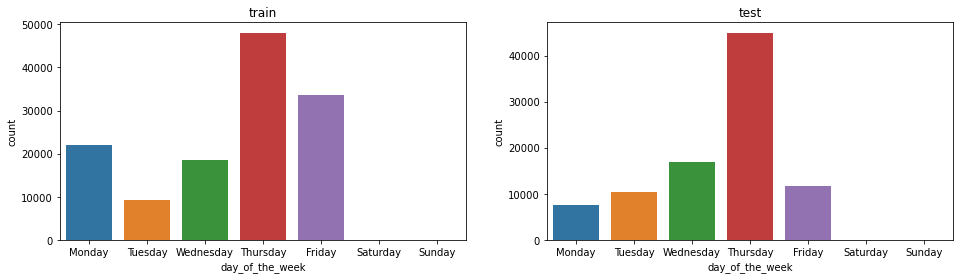

In [86]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

baseline_train_df = pd.read_csv(train_data_file_path);
add_day_of_the_week_info(baseline_train_df);
sns.countplot(x = "day_of_the_week",order = list(calendar.day_name),data = baseline_train_df,ax=ax[0])
ax[0].set_title("train");

baseline_test_df = pd.read_csv(test_data_file_path);
add_day_of_the_week_info(baseline_test_df);
sns.countplot(x = "day_of_the_week",order = list(calendar.day_name),data = baseline_test_df,ax=ax[1])
ax[1].set_title("test");

### 曜日ごとのパスの総数

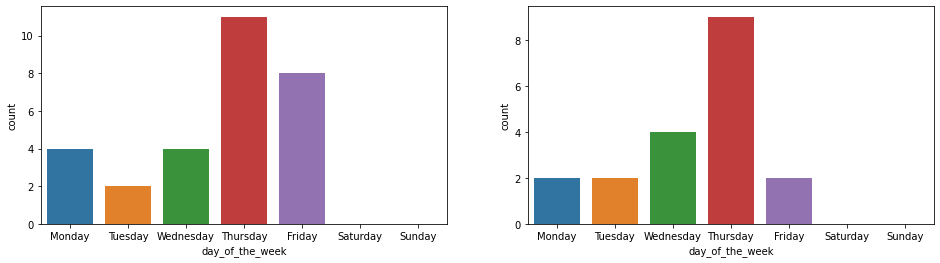

In [88]:
fig_path, ax_path = plt.subplots(1, 2, figsize=(16, 4))

erased = baseline_train_df[(baseline_train_df.shift(1).fillna("0")["collectionName"] != baseline_train_df["collectionName"])]
sns.countplot(x = "day_of_the_week",order = list(calendar.day_name),data = erased,ax=ax_path[0])
ax[0].set_title("train");

erased = baseline_test_df[(baseline_test_df.shift(1).fillna("0")["collectionName"] != baseline_test_df["collectionName"])]
sns.countplot(x = "day_of_the_week",order = list(calendar.day_name),data = erased,ax=ax_path[1])
ax[1].set_title("train");

#display(fig_path)

### 曜日ごとの実行時間 [分]
#### ベースラインの推定データ
テスト用データの金曜以外は平均実行時間は少し長いぐらいである。
テスト用データの金曜は、分散がでかいので、すごく長いパスが数個ある程度だと思われる。


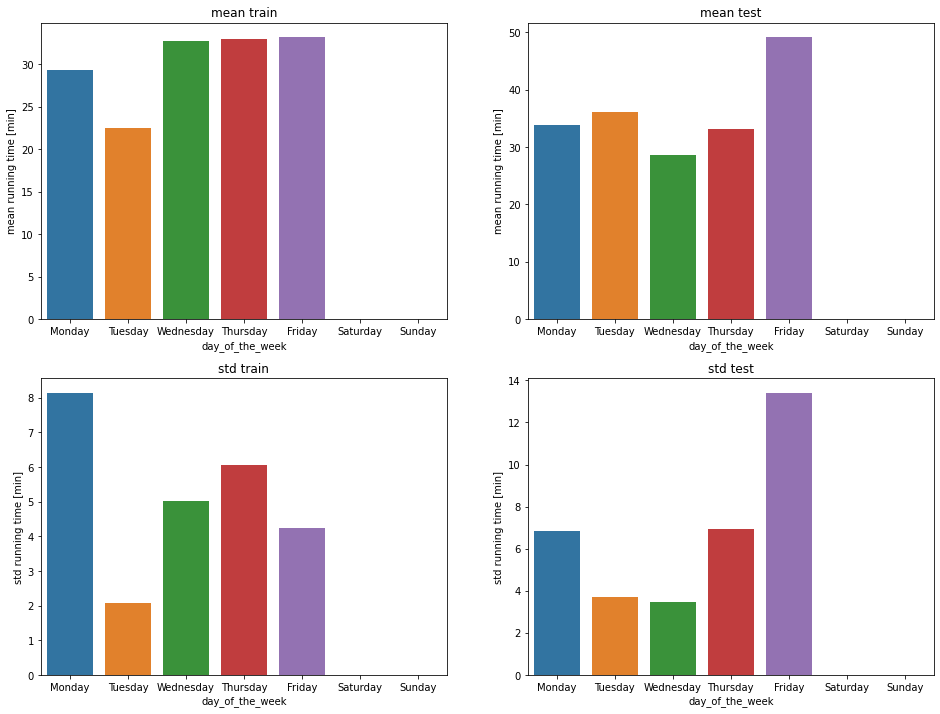

In [197]:
fig_path, ax_path = plt.subplots(2, 2, figsize=(16, 12))
collection_timedelta_hash = {}

for s,df in baseline_train_df.groupby("collectionName"):
    max_timestamp = df["millisSinceGpsEpoch"].max();
    min_timestamp = df["millisSinceGpsEpoch"].min();
    a = timedelta(seconds = (max_timestamp-min_timestamp)/1000);
    collection_timedelta_hash[s] = a.seconds/60;    
    
erased = baseline_train_df[(baseline_train_df.shift(1).fillna("0")["collectionName"] != baseline_train_df["collectionName"])]
add_day_of_the_week_info(erased);

erased["timedelta"] = erased["collectionName"].apply(lambda x:collection_timedelta_hash[x]);
erased_mean = erased.groupby(["day_of_the_week"]).mean();
erased_std = erased.groupby(["day_of_the_week"]).std();

sns.barplot(x = erased_mean.index,y=erased_mean["timedelta"], order = list(calendar.day_name),data = erased_mean,ax=ax_path[0][0])
sns.barplot(x = erased_std.index,y=erased_std["timedelta"], order = list(calendar.day_name),data = erased_std,ax=ax_path[1][0])

collection_timedelta_hash = {}

for s,df in baseline_test_df.groupby("collectionName"):
    max_timestamp = df["millisSinceGpsEpoch"].max()
    min_timestamp = df["millisSinceGpsEpoch"].min()
    a = timedelta(seconds = (max_timestamp-min_timestamp)/1000)
    collection_timedelta_hash[s] = a.seconds/60;    
    erased = baseline_test_df[(baseline_test_df.shift(1).fillna("0")["collectionName"] != baseline_test_df["collectionName"])]
    

add_day_of_the_week_info(erased);
erased["timedelta"] = erased["collectionName"].apply(lambda x:collection_timedelta_hash[x]);
erased_mean = erased.groupby(["day_of_the_week"]).mean();
erased_std = erased.groupby(["day_of_the_week"]).std();

sns.barplot(x = erased_mean.index,y=erased_mean["timedelta"], order = list(calendar.day_name),data = erased_mean,ax=ax_path[0][1])
sns.barplot(x = erased_std.index,y=erased_std["timedelta"], order = list(calendar.day_name),data = erased_std,ax=ax_path[1][1])


ax_path[0][0].set_ylabel("mean running time [min]");
ax_path[0][1].set_ylabel("mean running time [min]");
ax_path[1][0].set_ylabel("std running time [min]");
ax_path[1][1].set_ylabel("std running time [min]");


ax_path[0][0].set_title("mean train");
ax_path[0][1].set_title("mean test");
ax_path[1][0].set_title("std train");
ax_path[1][1].set_title("std test");


### 曜日ごとの平均移動距離

#### 関数

In [227]:
def calc_haversine(lat1, lon1, lat2, lon2):
    """
    Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist

#### データセット作成

In [238]:
display(df)

,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,timeSinceFirstFixSeconds,hDop,vDop,speedMps,courseDegree,dist
0,2020-06-04-US-MTV-1,Pixel4,1275339493441,37.416314,-122.080465,36.82,178.44,1.40,0.0,0.0,356.4,1.277385e+07
1,2020-06-04-US-MTV-1,Pixel4,1275339494441,37.416314,-122.080465,36.82,179.44,1.34,0.0,0.0,356.4,1.111256e-04
2,2020-06-04-US-MTV-1,Pixel4,1275339495441,37.416314,-122.080465,36.82,180.44,1.80,0.0,0.0,356.4,0.000000e+00
3,2020-06-04-US-MTV-1,Pixel4,1275339496441,37.416314,-122.080465,36.82,181.44,1.66,0.0,0.0,356.4,7.778709e-05
4,2020-06-04-US-MTV-1,Pixel4,1275339497441,37.416314,-122.080465,36.82,182.44,1.74,0.0,0.0,356.4,9.933722e-05
...,...,...,...,...,...,...,...,...,...,...,...,...
54598,2020-08-06-US-MTV-2,Pixel4,1280791335447,37.427345,-122.069912,34.47,2235.45,2.25,0.0,0.0,356.7,0.000000e+00
54599,2020-08-06-US-MTV-2,Pixel4,1280791336447,37.427345,-122.069912,34.47,2236.45,2.35,0.0,0.0,356.7,0.000000e+00
54600,2020-08-06-US-MTV-2,Pixel4,1280791337447,37.427345,-122.069912,34.47,2237.45,2.25,0.0,0.0,356.7,0.000000e+00
54601,2020-08-06-US-MTV-2,Pixel4,1280791338447,37.427345,-122.069912,34.47,2238.45,2.80,0.0,0.0,356.7,0.000000e+00
